In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)
np.random.seed(42)

2026-01-07 02:07:59.622079: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-07 02:07:59.745171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767731879.790856   34422 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767731879.803983   34422 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767731879.910823   34422 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
subset = 5000
x_train_small = x_train[:subset]
y_train_small = y_train[:subset]
input_shape = x_train_small.shape[1:]
num_classes = 10
print("Using subset size:", subset)

Using subset size: 5000


In [4]:
input_shape

(32, 32, 3)

In [5]:
strong_aug = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.GaussianNoise(0.05),
])

I0000 00:00:1767731883.254580   34422 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9468 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
identity_aug = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
], name="identity_aug")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 256
temperature = 0.2
epochs = 8

def make_simclr_ds(images, aug_fn):
    ds = tf.data.Dataset.from_tensor_slices(images)
    ds = ds.shuffle(10000)
    ds = ds.map(lambda x: (aug_fn(x, training=True), aug_fn(x, training=True)), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda a, b: (tf.cast(a, tf.float32), tf.cast(b, tf.float32)), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [8]:
ds_aug = make_simclr_ds(x_train_small, strong_aug)
ds_plain = make_simclr_ds(x_train_small, identity_aug)
ds_aug, ds_plain

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None))>)

## Encoder, projection head, and NT-Xent loss
We build a lightweight CNN encoder and a two-layer projection head. The NT-Xent loss uses cosine similarity with temperature scaling and treats the paired views as positives against all other images in the batch.

In [9]:
from tensorflow.keras import layers, models, optimizers

def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    return models.Model(inputs, x, name="encoder")

def build_projection_head():
    return models.Sequential([
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation=None)
    ], name="projection_head")

In [10]:
def nt_xent_loss(z1, z2, temperature=0.2):
    z1 = tf.math.l2_normalize(z1, axis=1)
    z2 = tf.math.l2_normalize(z2, axis=1)
    batch_size = tf.shape(z1)[0]
    representations = tf.concat([z1, z2], axis=0)

    similarity_matrix = tf.matmul(representations, representations, transpose_b=True)
    logits = similarity_matrix / temperature

    mask = tf.eye(2 * batch_size)
    logits = logits * (1 - mask) - 1e9 * mask

    labels = tf.concat([tf.range(batch_size, 2 * batch_size), tf.range(0, batch_size)], axis=0)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return tf.reduce_mean(loss)

In [11]:
def train_simclr(ds, name, epochs=epochs, temperature=temperature):
    encoder = build_encoder(input_shape)
    projection_head = build_projection_head()
    optimizer = optimizers.Adam(1e-3)
    trainable_vars = encoder.trainable_variables + projection_head.trainable_variables
    history = []

    for epoch in range(epochs):
        mean_loss = tf.metrics.Mean()
        for view1, view2 in ds:
            with tf.GradientTape() as tape:
                z1 = projection_head(encoder(view1, training=True), training=True)
                z2 = projection_head(encoder(view2, training=True), training=True)
                loss = nt_xent_loss(z1, z2, temperature)
            grads = tape.gradient(loss, trainable_vars)
            optimizer.apply_gradients(zip(grads, trainable_vars))
            mean_loss.update_state(loss)
        epoch_loss = mean_loss.result().numpy().item()
        history.append(epoch_loss)
        print(f"{name} epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f}")
    return history

In [12]:
loss_with_aug = train_simclr(ds_aug, name="With strong augmentation")
loss_no_aug = train_simclr(ds_plain, name="Without augmentation")

I0000 00:00:1767731884.543390   34422 cuda_dnn.cc:529] Loaded cuDNN version 91701
2026-01-07 02:08:07.272909: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


With strong augmentation epoch 1/8 - loss: 4.9650


2026-01-07 02:08:08.392972: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


With strong augmentation epoch 2/8 - loss: 3.6333
With strong augmentation epoch 3/8 - loss: 3.0964


2026-01-07 02:08:10.618523: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


With strong augmentation epoch 4/8 - loss: 2.8882
With strong augmentation epoch 5/8 - loss: 2.7760
With strong augmentation epoch 6/8 - loss: 2.6741
With strong augmentation epoch 7/8 - loss: 2.6132


2026-01-07 02:08:15.032196: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


With strong augmentation epoch 8/8 - loss: 2.5864
Without augmentation epoch 1/8 - loss: 4.8109
Without augmentation epoch 2/8 - loss: 3.5607
Without augmentation epoch 3/8 - loss: 2.9836
Without augmentation epoch 4/8 - loss: 2.7404
Without augmentation epoch 5/8 - loss: 2.6267
Without augmentation epoch 6/8 - loss: 2.5375
Without augmentation epoch 7/8 - loss: 2.4727
Without augmentation epoch 8/8 - loss: 2.4250


2026-01-07 02:08:20.182692: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


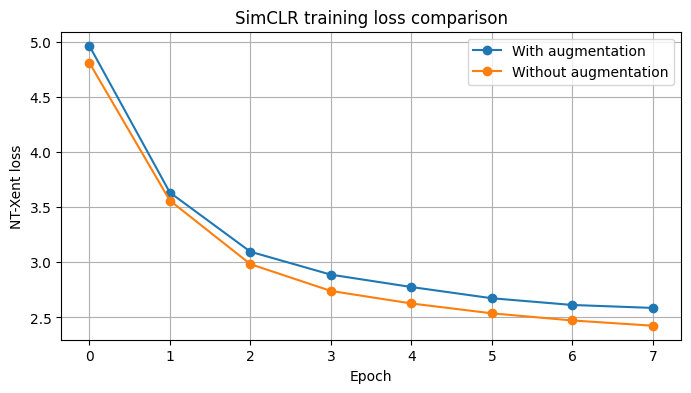

In [13]:
plt.figure(figsize=(8,4))
plt.plot(loss_with_aug, label='With augmentation', marker='o')
plt.plot(loss_no_aug, label='Without augmentation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent loss')
plt.title('SimCLR training loss comparison')
plt.legend()
plt.grid(True)
plt.show()